# Gau-GAN (Semantic Image Synthesis with Spatially-Adaptive Normalization)

This is an attempt to re-implement the paper Gau-GAN

Paper: https://arxiv.org/pdf/1903.07291.pdf

Other Resources: 
* https://nvlabs.github.io/SPADE
* https://keras.io/examples/generative/gaugan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow.python.eager import def_function

In [2]:
path = 'E:\\Image Datasets\\Facades\\facades_data\\facades_data'
batch_size = 1
image_size = 256 # higher resolution (>256) image is not available in dataset
train_size = 0.8
num_classes = 12

files = glob(path + '\\*.jpg')
train_files = files[:int(train_size*len(files))]
val_files = files[len(train_files):]
len(train_files), len(val_files)

(302, 76)

In [3]:
def load_data(image_files, is_train = True):
    def load_files(images, segmentations, labels):
        images = tf.io.decode_png(tf.io.read_file(images), channels = 3)
        segmentations = tf.io.decode_png(tf.io.read_file(segmentations), channels = 3)
        labels = tf.io.decode_bmp(tf.io.read_file(labels), channels = 0)
        
        images = tf.cast(images, tf.float32)/127.5 - 1
        segmentations = tf.cast(segmentations, tf.float32)/127.5 - 1
        labels = tf.squeeze(labels)
        return images, segmentations, labels
    
    def random_crop(images, segmentations, labels, crop_size = [image_size, image_size]):
        margin = tf.shape(images)[:2] - tf.convert_to_tensor(crop_size)
        x1 = tf.random.uniform((), minval = 0, maxval = margin[1], dtype = tf.int32)
        y1 = tf.random.uniform((), minval = 0, maxval = margin[0], dtype = tf.int32)
        x2 = x1 + crop_size[1]
        y2 = y1 + crop_size[0]
        
        images = images[y1:y2, x1:x2]
        segmentations = segmentations[y1:y2, x1:x2]
        labels = labels[y1:y2, x1:x2]
        return images, segmentations, labels
    
    segmentation_files = [image_file.replace('jpg', 'png') for image_file in image_files]
    label_files = [image_file.replace('jpg', 'bmp') for image_file in image_files]
    
    dataset = tf.data.Dataset.from_tensor_slices((image_files, segmentation_files, label_files))
    
    dataset = dataset.shuffle(10 * batch_size) if is_train else dataset
    dataset = dataset.map(load_files, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.map(random_crop, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.map(
        lambda x, y, z: (x, y, tf.one_hot(z, num_classes)), num_parallel_calls = tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size, drop_remainder = True)
    
    return dataset

In [4]:
train_data = load_data(train_files)
# next(iter(train_data))

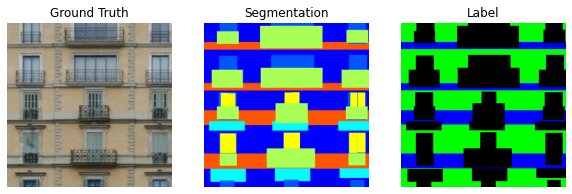

In [5]:
sample_data = next(iter(train_data))
idx = np.random.randint(9)

plt.figure(figsize = (10, 10))

plt.subplot(131)
plt.imshow(((sample_data[0][0]+1)*127.5).numpy().astype('uint8'))
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(132)
plt.imshow(((sample_data[1][0]+1)*127.5).numpy().astype('uint8'))
plt.title('Segmentation')
plt.axis('off')

plt.subplot(133)
plt.imshow(sample_data[2][0][:, :, idx:idx+3])
plt.title('Label')
plt.axis('off')

plt.show()

In [6]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon: float = 1e-8, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        
    def build(self, input_shape: tf.TensorShape):
        inp_chn = input_shape[-1]
        
        init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 1.0)
        self.ys = self.add_weight(shape = (1, 1, 1, inp_chn), initializer = init, 
                                  trainable = True, name = 'Scale')
        self.yb = self.add_weight(shape = (1, 1, 1, inp_chn), initializer = 'zeros', 
                                  trainable = True, name = 'Shift')
        
    def call(self, inputs):
        mean = tf.math.reduce_mean(inputs, axis = [1, 2], keepdims = True)
        rstd = tf.math.rsqrt(tf.math.reduce_variance(inputs, axis = [1, 2], keepdims = True) + self.epsilon)
        inst_norm = (inputs - mean) * rstd
        
        out = self.ys * inst_norm + self.yb
        return out

In [7]:
# referenced: spectral norm
# https://gist.github.com/FloydHsiu/828eea345e1ca6950e05bb42f0a75b50
# https://gist.github.com/FloydHsiu/ab33c7d98d78f9873757810e2f8db50d
class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, **kwargs):
        super().__init__(layer, **kwargs)
        pass
    
    def build(self, input_shape):
        
        if not self.layer.built:
            self.layer.build(input_shape)
            
        if not hasattr(self.layer, 'weight'):
            self.w = tf.convert_to_tensor(self.layer.get_weights()[0])
        else:
            self.w = tf.identity(self.layer.weight)
        
        if not hasattr(self, 'w'):
            raise ValueError()
        
        self.w_shape = self.w.shape.as_list()
        
        init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)
        self.u = self.add_weight(shape = (1, self.w_shape[-1]), initializer = init, 
                                   trainable = False, name = 'spectral_norm_u')
        
        # super().build()
        
    @def_function.function
    def call(self, inputs, training = None):
        if training is None:
            training = tf.keras.backend.learning_phase()
            
        if training == True:
            self._compute_weights()
            
        output = self.layer(inputs)
        return output
    
    def _compute_weights(self):
        w_reshaped = tf.reshape(self.w, (-1, self.w_shape[-1]))
        eps = 1e-12
        
        _u = tf.identity(self.u)
        _v = tf.matmul(_u, tf.transpose(w_reshaped, perm = [1, 0]))
        _v /= tf.maximum(tf.math.reduce_sum(_v ** 2) ** 0.5, eps)
        _u = tf.matmul(_v, w_reshaped)
        _u /= tf.maximum(tf.math.reduce_sum(_u ** 2) ** 0.5, eps)
        
        _u = tf.stop_gradient(_u)
        _v = tf.stop_gradient(_v)
        
        self.u.assign(_u)
        sigma = tf.matmul(tf.matmul(_v, w_reshaped), tf.transpose(_u, perm = [1, 0]))
        
        self.layer.weight.assign(self.w / sigma)

In [8]:
class Conv2D_(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides, gain = tf.sqrt(2.0), **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = 'SAME' if (kernel_size[0] - 1)//2 else 'VALID'
        self.gain = gain
        
    def build(self, input_shape):
        inp_filters = input_shape[-1]
        
        init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 1.0)
        self.weight = self.add_weight(shape = self.kernel_size + (inp_filters, self.filters), initializer = init, 
                                      trainable = True, name = 'weight')
        self.bias = self.add_weight(shape = (1, self.filters), initializer = init, 
                                    trainable = True, name = 'bias')
        
        fan_in = tf.cast(self.kernel_size[0] * self.kernel_size[1] * inp_filters, tf.float32)
        self.wscale = self.gain * tf.math.rsqrt(fan_in)
        
    def call(self, inputs):
        return tf.add(tf.nn.conv2d(inputs, self.weight * self.wscale, self.strides, self.padding, 'NHWC'), self.bias)
    
    
class Conv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides, gain = tf.sqrt(2.0), spectral_norm = True, **kwargs):
        super().__init__(**kwargs)
        if spectral_norm:
            self.conv = SpectralNormalization(Conv2D_(filters = filters, kernel_size = kernel_size, strides = strides, 
                                                      gain = gain))
        else:
            self.conv = Conv2D_(filters = filters, kernel_size = kernel_size, strides = strides, gain = gain)
        
        
    def call(self, inputs):
        return self.conv(inputs)

In [9]:
class SPADE(tf.keras.layers.Layer):
    def __init__(self, filters: int, norm = 'inst_norm', **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        
        self.conv = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), gain = tf.sqrt(2.0), 
                           spectral_norm = True)
        self.act = tf.keras.layers.ReLU()
        
        self.gamma_conv = Conv2D(filters = filters, kernel_size = (3, 3), strides = (1, 1), gain = tf.sqrt(2.0),  
                                 spectral_norm = True)
        self.beta_conv = Conv2D(filters = filters, kernel_size = (3, 3), strides = (1, 1), 
                                spectral_norm = True)
        
        if norm == 'batch_norm':
            self.norm = tf.keras.layers.BatchNormalization()
        elif norm == 'inst_norm':
            self.norm = InstanceNormalization()
        
    def call(self, inputs):
        x, mask = inputs
        inp_shp = tf.shape(x)
        
        mask = tf.image.resize(mask, inp_shp[1:3])
        out = self.act(self.conv(mask))
        gamma = self.gamma_conv(out)
        beta = self.beta_conv(out)
        
        '''
        mean = tf.math.reduce_mean(x, axis = [0, 1, 2], keepdims = True)
        rstd = tf.math.rsqrt(tf.math.reduce_variance(x, axis = [0, 1, 2], keepdims = True) + self.epsilon)
        norm = (x - mean) * rstd
        
        out = gamma * norm + beta
        '''
        
        out = self.norm(x) * gamma + beta
        return out

In [10]:
class SPADEResBlock(tf.keras.layers.Layer):
    def __init__(self, filters: int, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        
    def build(self, input_shape):
        inp_chn = input_shape[0][-1]
        self.skip_connect = inp_chn != self.filters
        
        self.spade_1 = SPADE(inp_chn)
        self.act_1 = tf.keras.layers.ReLU()
        self.conv_1 = Conv2D(filters = self.filters, kernel_size = (3, 3), strides = (1, 1), gain = tf.sqrt(2.0), 
                             spectral_norm = True)

        self.spade_2 = SPADE(self.filters)
        self.act_2 = tf.keras.layers.ReLU()
        self.conv_2 = Conv2D(filters = self.filters, kernel_size = (3, 3), strides = (1, 1), gain = tf.sqrt(2.0), 
                             spectral_norm = True)

        if self.skip_connect:
            self.spade_s = SPADE(inp_chn)
            self.act_s = tf.keras.layers.ReLU()
            self.conv_s = Conv2D(filters = self.filters, kernel_size = (3, 3), strides = (1, 1), gain = tf.sqrt(2.0), 
                                 spectral_norm = True)
            
    def call(self, inputs):
        x, mask = inputs
        skip = x
        
        out = self.conv_1(self.act_1(self.spade_1([x, mask])))
        out = self.conv_2(self.act_2(self.spade_2([out, mask])))
        
        if self.skip_connect:
            skip = self.conv_s(self.act_s(self.spade_s([skip, mask])))
        
        return tf.add(out, skip)

In [11]:
class GaussianSampler(tf.keras.layers.Layer):
    def __init__(self, batch_size: int, latent_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        
    def call(self, inputs):
        mean, var = inputs
        
        epsilon = tf.random.normal((self.batch_size, self.latent_dim), mean = 0.0, stddev = 1.0)
        out = mean + tf.exp(0.5 * var) + epsilon
        return out

In [12]:
class FeatureMatchingLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mae = tf.keras.losses.MeanAbsoluteError()
    
    def call(self, real, pred):
        loss = 0
        for r, p in zip(real, pred):
            loss += self.mae(r, p)
        return loss
    
class VGGFeatureMatchingLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        vgg_model = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
        layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
        self.mae = tf.keras.losses.MeanAbsoluteError()
        self.weights = [1/32, 1/16, 1/8, 1/4, 1]
        
        outs = [vgg_model.get_layer(layer).output for layer in layers]
        self.our_model = tf.keras.models.Model(vgg_model.inputs, outs)
        
    def call(self, real_img, gen_img):
        real_img = tf.keras.applications.vgg19.preprocess_input(real_img)
        gen_img = tf.keras.applications.vgg19.preprocess_input(gen_img)
        real_outs = self.our_model(real_img)
        gen_outs = self.our_model(gen_img)
        loss = 0
        
        for n, (r, p) in enumerate(zip(real_outs, gen_outs)):
            loss += self.weights[n] * self.mae(r, p)
        return loss
    
class DiscriminatorLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hinge_loss = tf.keras.losses.Hinge()
        
    def call(self, y_pred, is_true):
        label = 1.0 if is_true else -1.0
        return self.hinge_loss(label, y_pred)
    

def generator_loss(disc_gen_out):
    return -tf.reduce_mean(disc_gen_out)

def kl_divergence_loss(mean, var, kl_weight = 0.05):
    return (-0.5 * tf.reduce_sum(1 + var - tf.exp(var) - tf.square(mean))) * kl_weight

In [13]:
class GauGAN(tf.keras.models.Model):
    def __init__(self, image_shape: tuple, mask_seg_shape: tuple, mask_lbl_shape: tuple, latent_dim: int = 256, 
                 batch_size: int = batch_size, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.image_shape = image_shape
        self.mask_seg_shape = mask_seg_shape
        self.mask_lbl_shape = mask_lbl_shape
        self.batch_size = batch_size
        
    def call(self, inputs):
        return
        
    @property
    def __encoder(self):
        start_filter, end_filter = 64, 512
        inp = tf.keras.layers.Input(shape = self.image_shape, dtype = tf.float32, 
                                    name = f'encoder_input_{self.image_shape}')
        x = inp
        
        for _ in range(6): 
            x = tf.keras.layers.Conv2D(filters = start_filter, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x)
            x = InstanceNormalization()(x)
            x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
            
            start_filter = start_filter*2 if start_filter != 512 else start_filter
            
        x = tf.keras.layers.Flatten()(x)
        mean = tf.keras.layers.Dense(self.latent_dim)(x)
        var = tf.keras.layers.Dense(self.latent_dim)(x)
        
        gaussian_sampler = GaussianSampler(self.batch_size, self.latent_dim)([mean, var])
        
        return tf.keras.models.Model(inp, [mean, var, gaussian_sampler], name = 'encoder')
    
    @property
    def __generator(self):
        latent_inp = tf.keras.layers.Input(shape = (self.latent_dim), dtype = tf.float32, 
                                    name = f'generator_latent_input_{self.latent_dim}')
        mask_inp = tf.keras.layers.Input(shape = self.mask_lbl_shape, dtype = tf.float32, 
                                         name = f'generator_mask_input_{self.mask_lbl_shape}')
        
        x = tf.keras.layers.Dense(4*4*1024)(latent_inp)
        x = tf.keras.layers.Reshape((4, 4, 1024))(x)
        

        x = SPADEResBlock(1024)([x, mask_inp])
        
        x = tf.keras.layers.UpSampling2D(interpolation = 'nearest')(x) # 8x8
        x = SPADEResBlock(1024)([x, mask_inp])
        x = tf.keras.layers.UpSampling2D(interpolation = 'nearest')(x) # 16x16
        x = SPADEResBlock(1024)([x, mask_inp])
        x = tf.keras.layers.UpSampling2D(interpolation = 'nearest')(x) # 32x32
        x = SPADEResBlock(512)([x, mask_inp])
        x = tf.keras.layers.UpSampling2D(interpolation = 'nearest')(x) # 64x64
        x = SPADEResBlock(256)([x, mask_inp])
        x = tf.keras.layers.UpSampling2D(interpolation = 'nearest')(x) # 128x128
        x = SPADEResBlock(128)([x, mask_inp])
        x = tf.keras.layers.UpSampling2D(interpolation = 'nearest')(x) # 256x256
        # x = SPADEResBlock(1024)([x, mask_inp])
        # x = tf.keras.layers.UpSampling2D(interpolation = 'nearest')(x) # 512x512 (this resolution image not available in dataset)
        
        x = tf.keras.layers.Conv2D(filters = 3, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(x)
        x = tf.keras.layers.Activation('tanh')(x)
        
        return tf.keras.models.Model([latent_inp, mask_inp], x, name = 'generator')
    
    @property
    def __discriminator(self):
        img_inp = tf.keras.layers.Input(shape = self.image_shape, dtype = tf.float32, 
                                        name = f'discriminator_image_input_{self.image_shape}')
        mask_inp = tf.keras.layers.Input(shape = self.mask_seg_shape, dtype = tf.float32, 
                                         name = f'discriminator_segmentation_input_{self.mask_seg_shape}')
        
        x = tf.keras.layers.Concatenate()([img_inp, mask_inp])
        x1 = Conv2D(filters = 64, kernel_size = (4, 4), strides = (2, 2), gain = tf.sqrt(2.0), spectral_norm = True)(x)
        x1 = tf.keras.layers.LeakyReLU(alpha = 0.2)(x1)
        
        x2 = Conv2D(filters = 128, kernel_size = (4, 4), strides = (2, 2), gain = tf.sqrt(2.0), spectral_norm = True)(x1)
        x2 = InstanceNormalization()(x2)
        x2 = tf.keras.layers.LeakyReLU(alpha = 0.2)(x2)
        
        x3 = Conv2D(filters = 256, kernel_size = (4, 4), strides = (2, 2), gain = tf.sqrt(2.0), spectral_norm = True)(x2)
        x3 = InstanceNormalization()(x3)
        x3 = tf.keras.layers.LeakyReLU(alpha = 0.2)(x3)
        
        x4 = Conv2D(filters = 512, kernel_size = (4, 4), strides = (1, 1), gain = tf.sqrt(2.0), spectral_norm = True)(x3)
        x4 = InstanceNormalization()(x4)
        x4 = tf.keras.layers.LeakyReLU(alpha = 0.2)(x4)
        
        x5 = Conv2D(filters = 1, kernel_size = (4, 4), strides = (1, 1), gain = tf.sqrt(2.0), spectral_norm = True)(x4)
        return tf.keras.models.Model([img_inp, mask_inp], [x1, x2, x3, x4, x5], name = 'discriminator')
    
    def compile(self, generator_optimizer, discriminator_optimizer, 
                kl_divergence_loss, feature_matching_loss, vgg_feature_matching_loss, 
                discriminator_loss, generator_loss):
        super().compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.kl_divergence_loss = kl_divergence_loss
        self.feature_matching_loss = feature_matching_loss
        self.vgg_feature_matching_loss = vgg_feature_matching_loss
        self.discriminator_loss = discriminator_loss
        self.generator_loss = generator_loss
        
        self.encoder = self.__encoder
        self.generator = self.__generator
        self.discriminator = self.__discriminator
    
    def train_step(self, inputs):
        real_images, segmentation_images, label_images = inputs
        
        with tf.GradientTape(persistent = True) as tape:
            mean, var, gaussian_sample = self.encoder(real_images, training = True)
            gen_out = self.generator([gaussian_sample, label_images], training = True)
            
            disc_real_out = self.discriminator([real_images, segmentation_images], training = True)
            disc_gen_out = self.discriminator([gen_out, segmentation_images], training = True)
            
            kl_divergence_loss = self.kl_divergence_loss(mean, var, kl_weight = 1.0)
            feature_matching_loss = self.feature_matching_loss(disc_real_out, disc_gen_out)
            vgg_feature_matching_loss = self.vgg_feature_matching_loss((real_images+1)*127.5, (gen_out+1)*127.5)
            disc_loss_real = self.discriminator_loss(disc_real_out[-1], True)
            disc_loss_gen = self.discriminator_loss(disc_gen_out[-1], True)
            generator_loss = self.generator_loss(disc_gen_out[-1])
            
            tot_gen_loss = generator_loss + kl_divergence_loss + feature_matching_loss + vgg_feature_matching_loss
            tot_disc_loss = (disc_loss_real + disc_loss_gen) * 0.5
            
        gen_params = self.generator.trainable_variables + self.encoder.trainable_variables
        gen_grads = tape.gradient(tot_gen_loss, gen_params)
        self.optimizer.apply_gradients(zip(gen_grads, gen_params))
        
        disc_grads = tape.gradient(tot_disc_loss, self.discriminator.trainable_variables)
        self.optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
        
        return {'kl_divergence_loss': kl_divergence_loss, 
                'feature_matching_loss': feature_matching_loss, 
                'vgg_feature_matching_loss': vgg_feature_matching_loss, 
                'generator_loss': generator_loss, 
                'total_generator_loss': tot_gen_loss, 
                'total_discriminator_loss': tot_disc_loss}

In [14]:
g_gan = GauGAN((image_size, image_size, 3), (image_size, image_size, 3), (image_size, image_size, num_classes))
g_gan.compile(
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.0, beta_2 = 0.999),
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0004, beta_1 = 0.0, beta_2 = 0.999),
    kl_divergence_loss = kl_divergence_loss,
    feature_matching_loss = FeatureMatchingLoss(),
    vgg_feature_matching_loss = VGGFeatureMatchingLoss(),
    generator_loss = generator_loss,
    discriminator_loss = DiscriminatorLoss()
)

In [ ]:
g_gan.fit(train_data, epochs = 5, steps_per_epoch = 10, batch_size = batch_size)

Epoch 1/5
 6/10 [=================>............] - ETA: 1s - kl_divergence_loss: 1430.3670 - feature_matching_loss: 0.2935 - vgg_feature_matching_loss: 235.9473 - generator_loss: 0.1138 - total_generator_loss: 1666.7216 - total_discriminator_loss: 1.1137

In [ ]:
plt.imshow(((g_gan.generator([tf.random.normal((1, 256)), sample_data[-1]])[0]+1)*127.5).numpy().astype('uint8'));

In [ ]:
# plt.imshow(((sample_data[0][0]+1)*127.5).numpy().astype('uint8'))

In [ ]:
# gg = GauGAN((image_size, image_size, 3), (image_size, image_size, 3), (image_size, image_size, 12))
# # gg.encoder().summary()
# gg.generator().summary()
# # gg.discriminator().summary()

In [ ]:
# tf.keras.utils.plot_model(gg.discriminator(), show_shapes = True, dpi = 64)